<a href="https://colab.research.google.com/github/ankokovin/BlocklyForHouse/blob/master/NN_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from google.colab import drive
from tqdm.notebook import tqdm
import json
import torch
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [0]:
df = pd.read_excel('/gdrive/My Drive/Colab Notebooks/data.xlsx')
df.head()

Отметка времени  ... Возраст
0 2017-11-10 17:22:35.819  ...     NaN
1 2017-11-10 18:07:39.304  ...     NaN
2 2017-11-10 18:08:25.519  ...     NaN
3 2017-11-10 18:08:31.259  ...     NaN
4 2017-11-10 18:09:06.280  ...     NaN

[5 rows x 37 columns]

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 37 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype         
---  ------                                                                                                                              --------------  -----         
 0   Отметка времени                                                                                                                     4801 non-null   datetime64[ns]
 1   1.                                                                                                                                  4801 non-null   object        
 2   2.                                                                                                                                  4801 non-null   object        
 3   3.                                              

In [0]:
import datetime
ndf = pd.DataFrame()
info = [
        {
    'name': 'Пол',
    'type': 'choice',
    'separate': False,
    'question': 'Ваш пол',
    'answers': {
        'Женский': 0,
        'Мужской': 1
        }
    },
    {
        'name':'Возраст',
        'type': 'numeric',
        'question': 'Возраст в годах'
    },
    {
        'name':'Образование',
        'type':'choice',
       'separate': True,
       'question': 'Уровень образования',
       'answers': df['Образование'].unique().tolist()
    },{
        'name':'Доход',
        'type': 'choice',
        'separate': False,
        'question': 'Уровень дохода в месяц',
        'answers': {
            'Свыше 90 тыс.' : 10,
            '60-90 тыс.' : 7.5,
            '30-60 тыс.' : 4.5,
            '20-30 тыс.' : 2.5,
            'Менее 20 тыс.': 1
        }
    },{
        'name':'Семейное положение',
       'question':'Семейное положение',
        'type': 'choice',
       'separate':True,
       'answers':list(df['Семейное положение'].unique())
    },{
        'name':'Рост (см)',
       'type':'numeric',
       'question':'Рост (см)',
       'ignore': False
    },{
        'name':'Вес (кг)',
       'type':'numeric',
       'question':'Вес (кг)',
       'ignore': False
    },{
        'name': 'Детство',
       'type': 'choice',
       'question': 'Подвергались ли вы унижениям и плохому обращению в детстве?',
       'answers': {
           'Да': 1,
           'Нет': 0
       },
    },{
        'name': 'Потеря родителей',
       'type': 'choice',
       'question': 'Переживали ли вы раннюю утрату родителей?',
       'answers': {
           'Да': 1,
           'Нет': 0
       },
    },{
        'name': 'Родственники',
       'type': 'choice',
       'question': 'Имеется ли у кого-то из кровных родственников склонность к депрессии? (Кровные родственники — лица, имеющие одного общего предка.)',
       'answers': {
           'Да': 1,
           'Нет': 0
       },
    },{
        'name': 'Творчество',
       'type': 'choice',
       'question': 'Ваша деятельность связана с творчеством?',
       'answers': {
           'Да': 1,
           'Нет': 0
       },
    },{
        'name': 'Умственный труд',
       'type': 'choice',
       'question': 'С каким видом труда связана ваша деятельность?',
       'answers': {
           'Умственный': 1,
           'Физический': 0
       },
    },{
        'name': 'Близкие',
       'type': 'choice',
       'question': 'Имеется ли у кого-то из близких вам людей (не включая кровных родственников) склонность к депрессии?',
       'answers': {
           'Да': 1,
           'Нет': 0
       },
    },{
        'name': 'Заболевание',
       'type': 'choice',
       'question': 'Страдаете ли вы от хронических заболеваний?',
       'answers': {
           'Да': 1,
           'Нет': 0
       },
    },{
       'name': 'Индекс массы тела (BMI)',
       'type': 'calc',
       'code': 'import numpy as np; df["Индекс массы тела (BMI)"]=df["Вес (кг)"] / np.power(df["Рост (см)"]/100,2)',
       'ignore': True
    },
    {
        'name': 'Идеальная масса (Devine)',
       'type': 'calc',
       'code': 'import numpy as np; df["Идеальная масса (Devine)"]=45.5 + df["Пол"]*(50-45.5)+0.9*(df["Рост (см)"]-152)',
        'ignore': True
    },
]
ndf['Пол'] = df['Пол'].apply(lambda x:(1 if x[0]=='М' else 0) if isinstance(x,str) else x).astype('float64')

#df['Возраст'] = datetime.datetime.now() - pd.to_datetime(df['Дата рождения'], format='%y-%m-%d %H:%M:%S', errors='ignore')

df ['Возраст'] = (pd.Timestamp.now() - pd.to_datetime(df['Дата рождения'], errors='coerce')).apply(lambda x:x.days/365.24)
ndf['Возраст'] = df['Возраст']
for i in df['Образование'].unique():
    ndf['Образование:'+i] = (df['Образование'] == i).astype('float64')

money =  {
            'Свыше 90 тыс.' : 10,
            '60-90 тыс.' : 7.5,
            '30-60 тыс.' : 4.5,
            '20-30 тыс.' : 2.5,
            'Менее 20 тыс.': 1
        }
ndf['Доход'] = df['Уровень дохода в месяц'].apply(lambda x:money[x]).astype('float64')
for i in df['Семейное положение'].unique():
    ndf[i] = (df['Семейное положение'] == i).astype('float64')
ndf['Рост (см)'] = df['Рост (см)'].astype('float64')
ndf['Вес (кг)'] = df['Вес (кг)'].astype('float64')
#ndf['Индекс массы тела (BMI)'] = ndf['Вес (кг)'] / np.power(ndf['Рост (см)']/100,2)
#ndf['Идеальная масса (Devine)'] = 45.5 + ndf['Пол']*(50-45.5)+0.9*(ndf['Рост (см)']-152)
ndf['Детство'] = (df['Подвергались ли вы унижениям и плохому обращению в детстве?'] == 'Да').astype('float64')
ndf['Потеря родителей'] = (df['Переживали ли вы раннюю утрату родителей?']== 'Да').astype('float64')
ndf['Родственники'] = (df['Имеется ли у кого-то из кровных родственников склонность к депрессии? (Кровные родственники — лица, имеющие одного общего предка.)'] == 'Да').astype('float64')
ndf['Творчество'] = (df['Ваша деятельность связана с творчеством?']== 'Да').astype('float64')
ndf['Умственный труд'] = (df['С каким видом труда связана ваша деятельность?'] == 'Умственный').astype('float64')
ndf['Близкие'] = (df['Имеется ли у кого-то из близких вам людей (не включая кровных родственников) склонность к депрессии?'] == 'Да').astype('float64')
ndf['Заболевание'] = (df['Страдаете ли вы от хронических заболеваний?'] == 'Да').astype('float64')
for col in info:
    if col['type'] == 'calc':
        exec(col['code'],{
            'df': ndf
        })
def depression_level(s):
    l = [9, 18, 29]
    for i in range(len(l)):
        if s <= l[i]:
            return i
    return 3
labels = [str(i+1)+'.' for i in range (21)]
for l in labels:
    df[l] = df[l].apply(lambda x:int(x[0]) if isinstance(x,str) else x)
ndf['Депрессия'] = df[labels].sum(axis=1).apply(depression_level)
ndf.head()

Пол    Возраст  ...  Идеальная масса (Devine)  Депрессия
0  1.0  70.518016  ...                      77.9          1
1  0.0  24.274450  ...                      52.7          1
2  1.0  23.986967  ...                      75.2          1
3  0.0  26.817983  ...                      60.8          2
4  0.0  23.064286  ...                      61.7          0

[5 rows x 23 columns]

In [0]:
rename = {}
for i in info:
    if 'question' in i:
        rename[i['question']] = i['name']
print(rename)
df.rename(columns=rename, inplace=True)
df.head()

{'Ваш пол': 'Пол', 'Возраст в годах': 'Возраст', 'Уровень образования': 'Образование', 'Уровень дохода в месяц': 'Доход', 'Семейное положение': 'Семейное положение', 'Рост (см)': 'Рост (см)', 'Вес (кг)': 'Вес (кг)', 'Подвергались ли вы унижениям и плохому обращению в детстве?': 'Детство', 'Переживали ли вы раннюю утрату родителей?': 'Потеря родителей', 'Имеется ли у кого-то из кровных родственников склонность к депрессии? (Кровные родственники — лица, имеющие одного общего предка.)': 'Родственники', 'Ваша деятельность связана с творчеством?': 'Творчество', 'С каким видом труда связана ваша деятельность?': 'Умственный труд', 'Имеется ли у кого-то из близких вам людей (не включая кровных родственников) склонность к депрессии?': 'Близкие', 'Страдаете ли вы от хронических заболеваний?': 'Заболевание'}


Отметка времени  1.  2.  ...  Заболевание  Умственный труд    Возраст
0 2017-11-10 17:22:35.819   0   1  ...           Да       Умственный  70.518016
1 2017-11-10 18:07:39.304   1   0  ...          Нет       Умственный  24.274450
2 2017-11-10 18:08:25.519   0   0  ...          Нет       Умственный  23.986967
3 2017-11-10 18:08:31.259   1   3  ...          Нет       Умственный  26.817983
4 2017-11-10 18:09:06.280   0   0  ...          Нет       Умственный  23.064286

[5 rows x 37 columns]

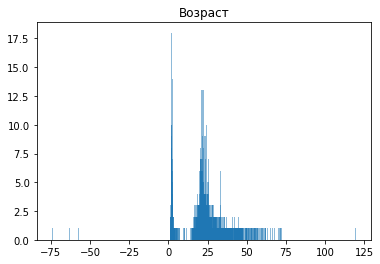

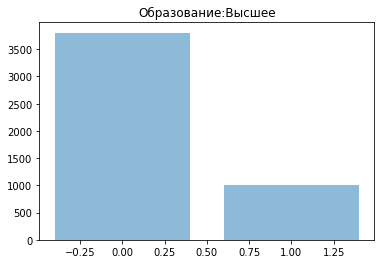

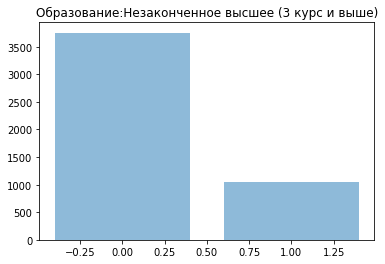

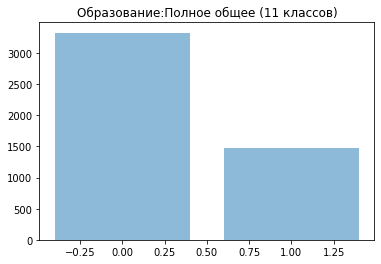

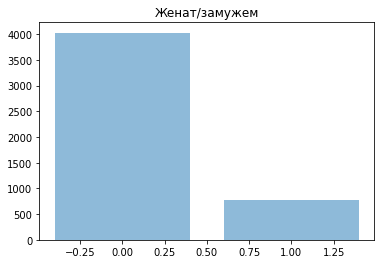

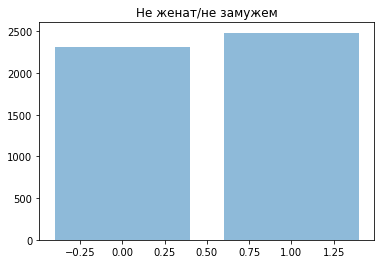

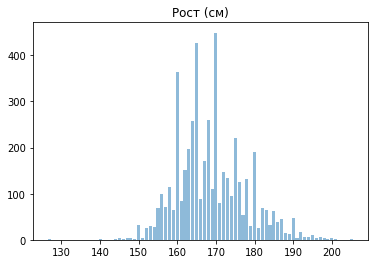

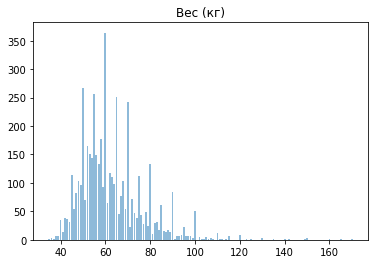

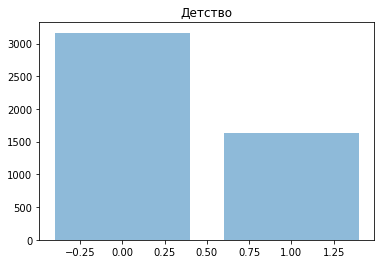

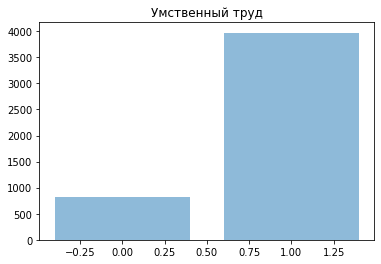

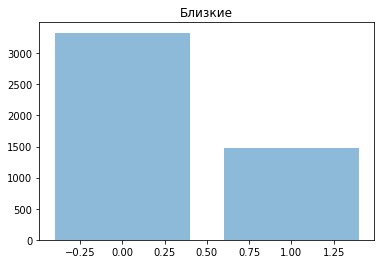

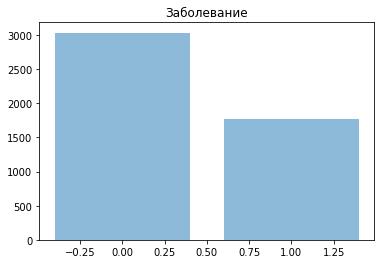

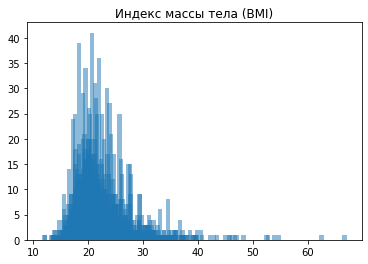

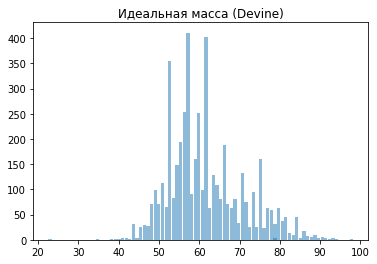

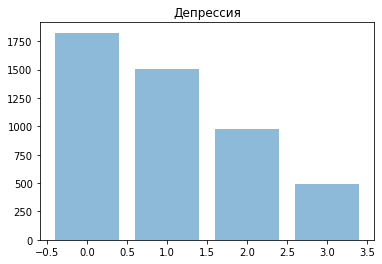

In [0]:
import matplotlib.pyplot as plt
def plot_df():
    for label in ndf.columns:
        count = ndf[label].value_counts()
        plt.bar(count.index, count, alpha=0.5)
        plt.title(label)
        plt.show()

plot_df()

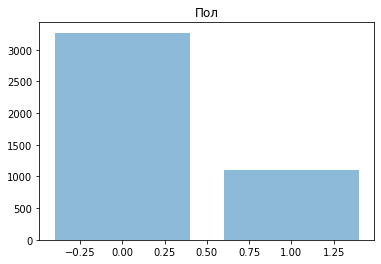

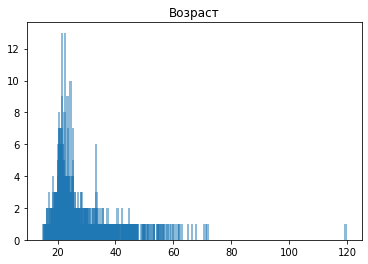

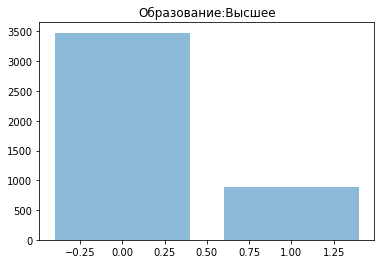

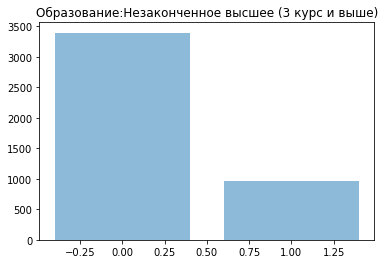

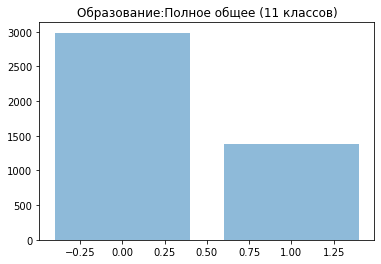

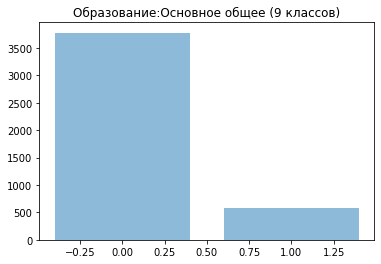

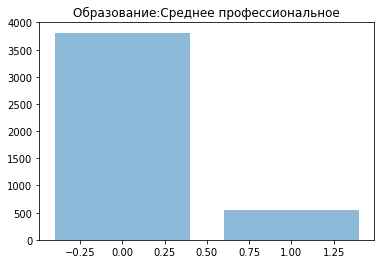

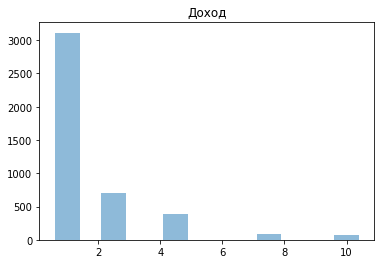

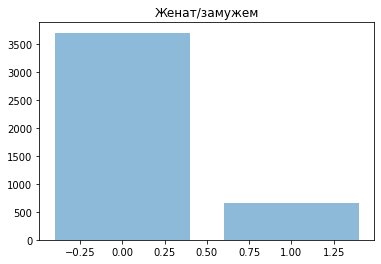

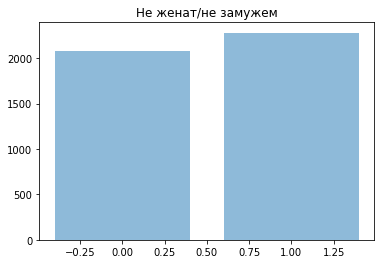

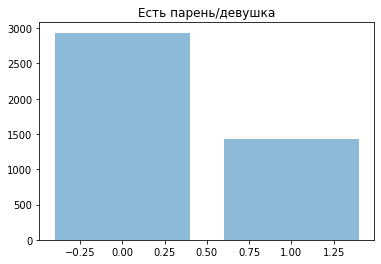

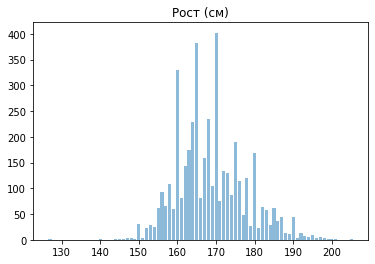

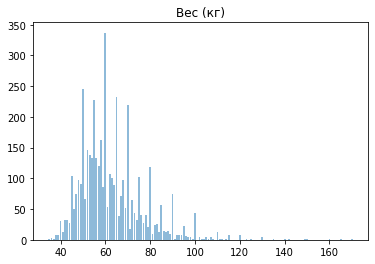

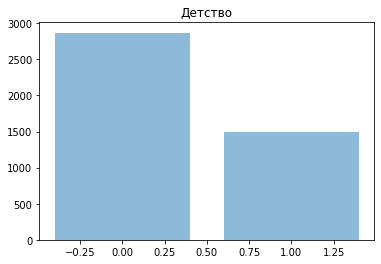

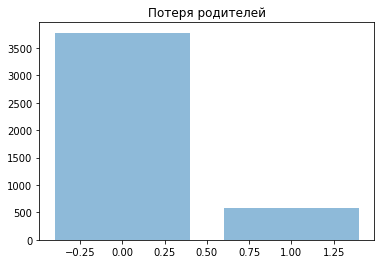

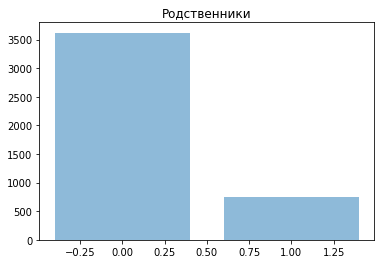

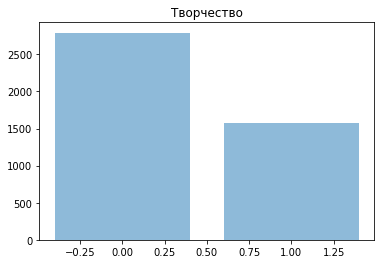

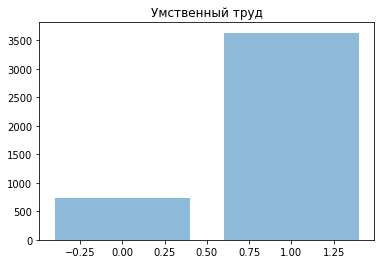

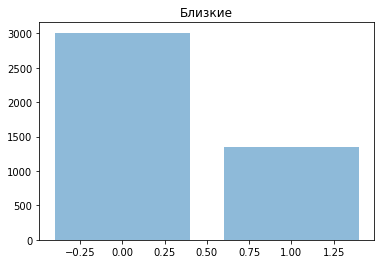

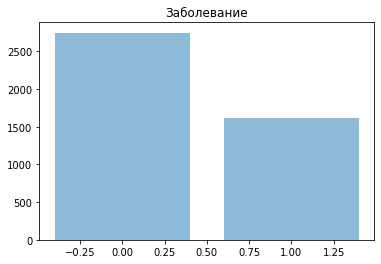

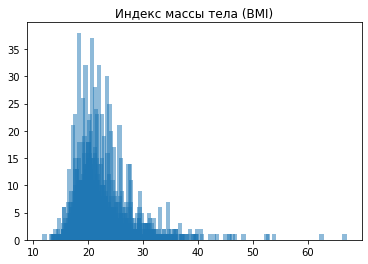

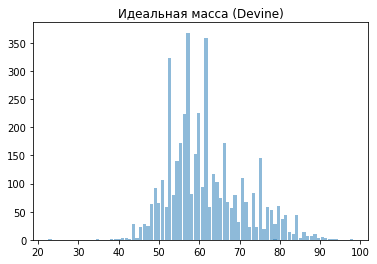

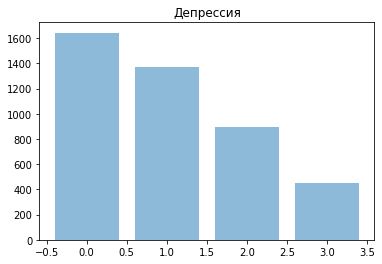

In [0]:
ndf = ndf[ndf['Возраст'] >= 15]
df = df[df['Возраст'] >= 15]
plot_df()

In [0]:
for i in ndf.columns:
    print(i)

print('---')

for i in info:
    print(i['name'])

Пол
Возраст
Образование:Высшее
Образование:Незаконченное высшее (3 курс и выше)
Образование:Полное общее (11 классов)
Образование:Основное общее (9 классов)
Образование:Среднее профессиональное
Доход
Женат/замужем
Не женат/не замужем
Есть парень/девушка
Рост (см)
Вес (кг)
Детство
Потеря родителей
Родственники
Творчество
Умственный труд
Близкие
Заболевание
Индекс массы тела (BMI)
Идеальная масса (Devine)
Депрессия
---
Пол
Возраст
Образование
Доход
Семейное положение
Рост (см)
Вес (кг)
Детство
Потеря родителей
Родственники
Творчество
Умственный труд
Близкие
Заболевание
Индекс массы тела (BMI)
Идеальная масса (Devine)


{'columns': [{'name': 'Пол', 'type': 'choice', 'separate': False, 'question': 'Ваш пол', 'answers': {'Женский': 0, 'Мужской': 1}}, {'name': 'Возраст', 'type': 'numeric', 'question': 'Возраст в годах', 'mean': 24.321096098256145, 'std': 6.31138861249887}, {'name': 'Образование', 'type': 'choice', 'separate': True, 'question': 'Уровень образования', 'answers': ['Высшее', 'Незаконченное высшее (3 курс и выше)', 'Полное общее (11 классов)', 'Основное общее (9 классов)', 'Среднее профессиональное']}, {'name': 'Доход', 'type': 'choice', 'separate': False, 'question': 'Уровень дохода в месяц', 'answers': {'Свыше 90 тыс.': 10, '60-90 тыс.': 7.5, '30-60 тыс.': 4.5, '20-30 тыс.': 2.5, 'Менее 20 тыс.': 1}, 'mean': 1.8289775332416323, 'std': 1.7117749849849573}, {'name': 'Семейное положение', 'question': 'Семейное положение', 'type': 'choice', 'separate': True, 'answers': ['Женат/замужем', 'Не женат/не замужем', 'Есть парень/девушка']}, {'name': 'Рост (см)', 'type': 'numeric', 'question': 'Рост (с

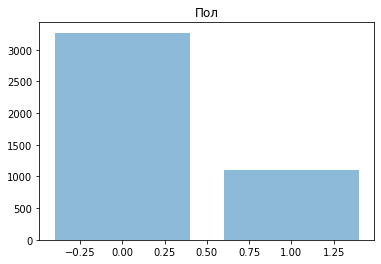

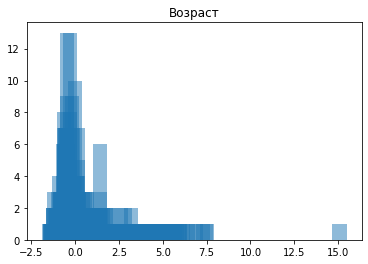

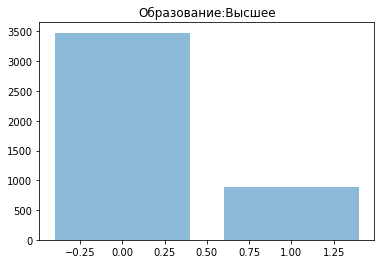

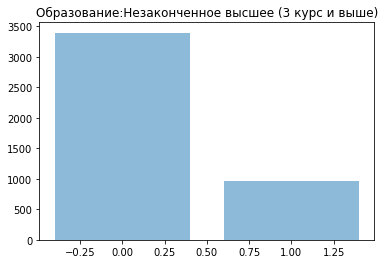

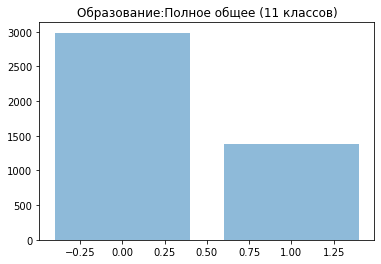

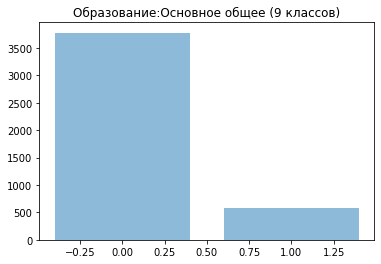

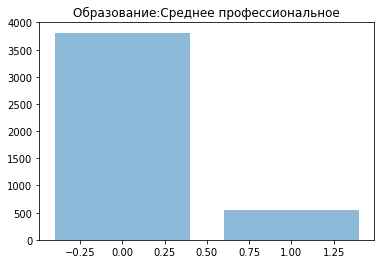

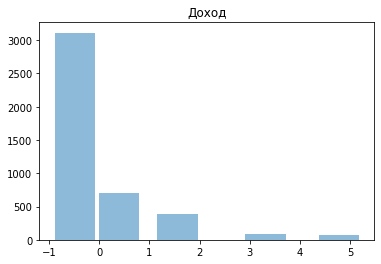

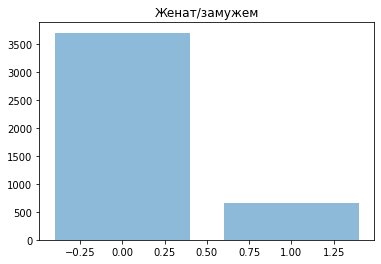

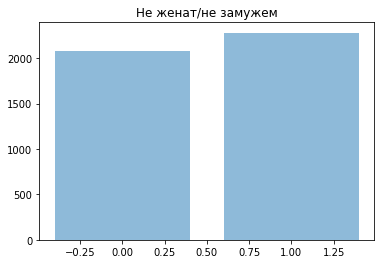

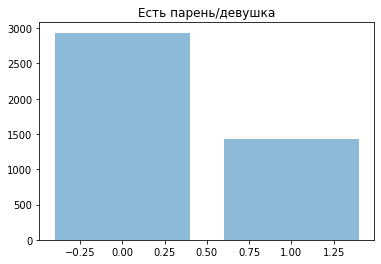

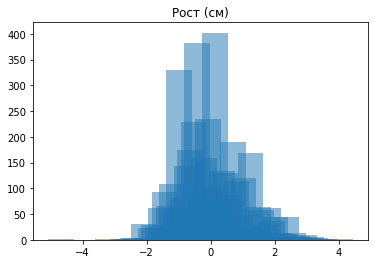

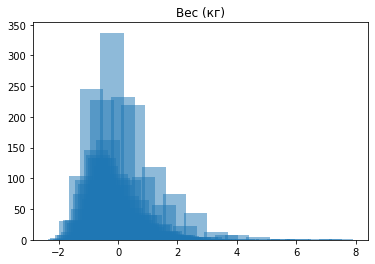

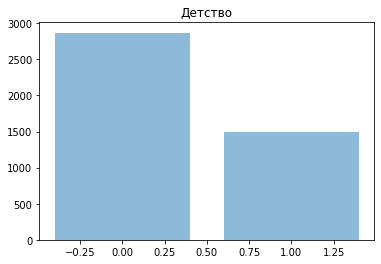

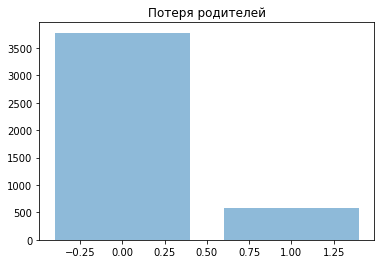

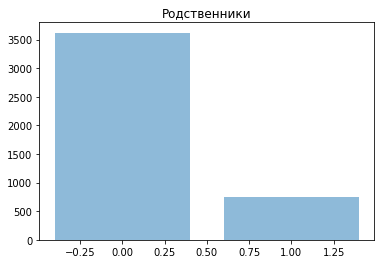

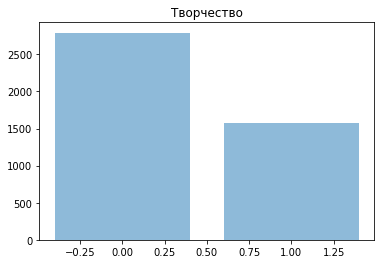

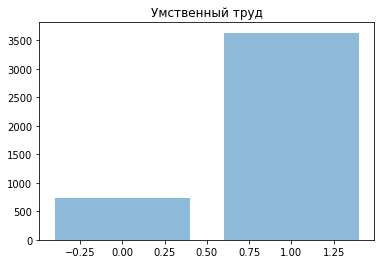

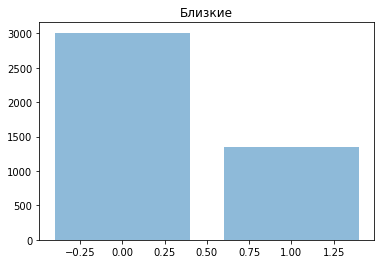

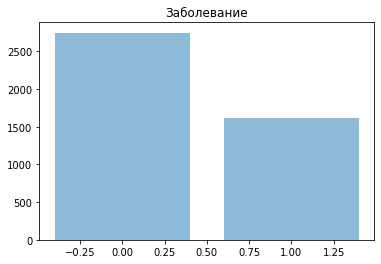

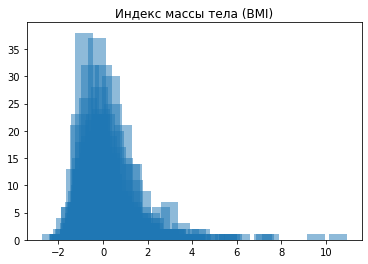

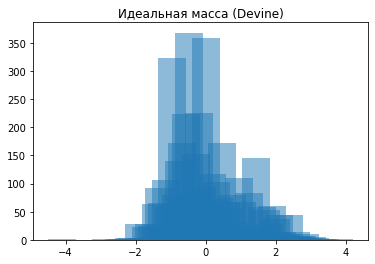

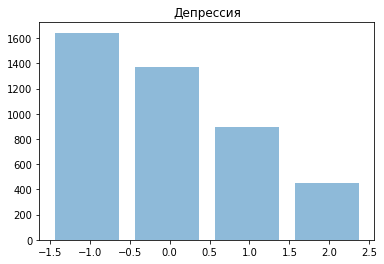

In [0]:
z_norm_list = ['Вес (кг)','Возраст','Идеальная масса (Devine)','Индекс массы тела (BMI)', 'Рост (см)', 'Доход']
for label in z_norm_list:
    if label in ndf.columns:
        m = ndf[label].mean()
        s = ndf[label].std(ddof=0)
        for col in info:
            if col['name'] == label:
                col['mean'] = m
                col['std'] = s
        ndf[label] = (ndf[label] - m)/s
m = ndf['Депрессия'].mean()
s = ndf['Депрессия'].std(ddof=0)
ndf['Депрессия'] = (ndf['Депрессия'] - m)/s
info = {'columns':info, 'out':{'mean':m, 'std':s}}
 

print(info)
plot_df()

In [0]:
drops = ['Депрессия']
for column in info['columns']:
    if 'ignore' in column and column['ignore'] == True:
        drops.append(column['name'])
x = ndf.drop(drops, axis=1)
y = ndf['Депрессия']
x.head()

Пол   Возраст  Образование:Высшее  ...  Умственный труд  Близкие  Заболевание
0  1.0  7.319613                 1.0  ...              1.0      0.0          1.0
1  0.0 -0.007391                 0.0  ...              1.0      0.0          0.0
2  1.0 -0.052941                 1.0  ...              1.0      0.0          0.0
3  0.0  0.395616                 1.0  ...              1.0      0.0          0.0
4  0.0 -0.199134                 0.0  ...              1.0      0.0          0.0

[5 rows x 20 columns]

In [0]:
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class Net(nn.Module):
    def get_torch_act_function(name):
        if not isinstance(name, str):
            raise ValueError('Expected string for a name of activation function')
        elif name == 'tanh':
            return nn.Tanh()
        elif name == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError('Activation function "'+name+"' is not defined")

    def __init__(self, hidden_cnt,input_count,output_count,act_function='sigmoid'):
        super(Net, self).__init__()
        if not isinstance(hidden_cnt, int) or hidden_cnt<1:
            raise ValueError('hidden_cnt must be a natrual number')
        self.act_function_name = act_function
        self.act_function = Net.get_torch_act_function(act_function)
        self.input_layer = nn.Linear(input_count,hidden_cnt)
        self.output_layer = nn.Linear(hidden_cnt, output_count) 
        self.hidden_cnt = hidden_cnt
    def forward(self, x):
        x = self.act_function(self.input_layer(x))
        x = self.act_function(self.output_layer(x))
        return x

net = Net(3,len(x.columns),1 ,'sigmoid')

net.to(device)
print(net)

Running on the GPU
Net(
  (act_function): Sigmoid()
  (input_layer): Linear(in_features=20, out_features=3, bias=True)
  (output_layer): Linear(in_features=3, out_features=1, bias=True)
)


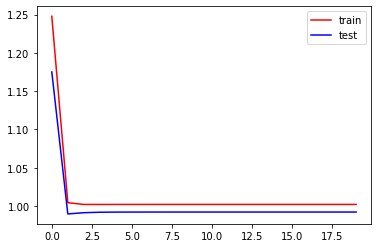

In [0]:
#@title Обучение
import random
import time


def train_best(x_train, y_train, x_test, y_test,hidden_cnt, act_f, optim, err_f,err_cmp, lrs, epochs, nn_count):
    result = None
    result_score = None

    best_xs = None
    best_trainlosses = None
    best_testlosses = None
    try:
        for nn in tqdm(range(nn_count), leave=False):
            xs = []
            trainlosses = []
            testlosses = []
            # Выбор функции активации
            activation_function = random.choice(act_f) if isinstance(act_f, list) else act_f
            # Создадим сеть
            n = random.choice(hidden_cnt)if isinstance(hidden_cnt, list) else hidden_cnt
            net = Net(n,x_train.shape[1],y_train.shape[1],activation_function)
            net.to(device)
            # Осуществляем оптимизацию путем стохастического градиентного 
            learning_rate = random.choice(lrs) if isinstance(lrs, list) else lrs
            optimizer = random.choice(optim)(net.parameters(), lr=learning_rate) if isinstance(optim, list) else optim(net.parameters(), lr=learning_rate)        
            # Создаем функцию потерь
            criterion = random.choice(err_f) if isinstance(err_f, list) else err_f
            # запускаем главный тренировочный цикл
            best_score = None
            for epoch in tqdm(range(epochs), leave=False):
                optimizer.zero_grad()
                net_out = net(x_train)
                loss = criterion(net_out, y_train)
                test_loss = criterion(net(x_test), y_test).item()
                loss.backward()
                optimizer.step()
                if best_score == None or test_loss < best_score:
                    torch.save(net.state_dict(), 'tempmodel.pt')
                    best_score = test_loss
                xs.append(epoch)
                trainlosses.append(loss.item())
                testlosses.append(test_loss)
 
            net = Net(n,x_train.shape[1],y_train.shape[1],activation_function)
            net.to(device)
            state_dict = torch.load('tempmodel.pt', device)
            net.load_state_dict(state_dict)
            net.eval()
            net_out = net(x_test)
            test_loss = err_cmp(net_out, y_test).data.item()
            if result_score is None or result_score < test_loss:
                result = net
                result_score = test_loss
                best_xs = xs
                best_trainlosses = trainlosses
                best_testlosses = testlosses

    except KeyboardInterrupt:
        pass
    plt.plot(best_xs, best_trainlosses,'r-', label='train')
    plt.plot(best_xs, best_testlosses,'b-', label='test')
    plt.legend(('train','test'))
    plt.show()
    return result, result_score


epochs =  20#@param {type:"integer"}
tries =  1#@param {type:"integer"}

train_ratio = 0.8

msk = np.random.rand(len(ndf)) < train_ratio

train_x = torch.tensor(x[msk].values).float().to(device)
#print(train_x.shape)
test_x = torch.tensor(x[~msk].values).float().to(device)
#print(test_x.shape)
train_y = torch.tensor(y[msk].values).float().to(device)
train_y = train_y.view(train_y.shape[0], 1)
#print(train_y.shape)
test_y = torch.tensor(y[~msk].values).float().to(device)
test_y = test_y.view(test_y.shape[0], 1)
#print(test_y.shape)
cnts = list(range(3,20))
act_f = [
         'sigmoid',
         'tanh'
]
optim = [
         torch.optim.Adam,
         torch.optim.SGD
]
err_f = [
         torch.nn.MSELoss(),
         torch.nn.L1Loss()
]
nns, result_score = train_best(train_x,                        # x_train
                train_y,   # y_train
                test_x,                         # x_test
                test_y,    # y_test
                cnts,                           # hidden_cnt
                act_f,                          # act_f
                optim,                          # optim
                err_f,                          # err_f     
                torch.nn.L1Loss(),              # err_cmp
                np.logspace(0.001,0.1).tolist(),# lrs
                epochs,                          # epochs
                tries                              # nn_count
                )                            

In [0]:
configs = []
for ignore_w_h in [True, False]:
    for use_bmi in [True, False]:
        for use_devine in [True, False]:
            for use_age in [True, False]:
                for use_life in [True, False]:
                    if use_life:
                        t = [True, False]
                    else:
                        t = [False]  
                    for separate_education in t:
                        for separate_fam_status in t:
                            name = "No wh " if ignore_w_h else "Wh "
                            columns = [
                                {
                                'name': 'Пол',
                                'type': 'choice',
                                'separate': False,
                                'question': 'Ваш пол',
                                'answers': {
                                    'Женский': 0,
                                    'Мужской': 1
                                    }
                                }, {
                                'name': 'Детство',
                                'type': 'choice',
                                'question': 'Подвергались ли вы унижениям и плохому обращению в детстве?',
                                'answers': {
                                    'Да': 1,
                                    'Нет': 0
                                },
                                },{
                                'name': 'Потеря родителей',
                                'type': 'choice',
                                'question': 'Переживали ли вы раннюю утрату родителей?',
                                'answers': {
                                    'Да': 1,
                                    'Нет': 0
                                    },
                                },{
                                'name': 'Родственники',
                                'type': 'choice',
                                'question': 'Имеется ли у кого-то из кровных родственников склонность к депрессии? (Кровные родственники — лица, имеющие одного общего предка.)',
                                'answers': {
                                    'Да': 1,
                                    'Нет': 0
                                },
                                },{
                                'name': 'Творчество',
                                'type': 'choice',
                                'question': 'Ваша деятельность связана с творчеством?',
                                'answers': {
                                    'Да': 1,
                                    'Нет': 0
                                },
                                },{
                                'name': 'Умственный труд',
                                'type': 'choice',
                                'question': 'С каким видом труда связана ваша деятельность?',
                                'answers': {
                                    'Умственный': 1,
                                    'Физический': 0
                                },
                                },{
                                'name': 'Близкие',
                                'type': 'choice',
                                'question': 'Имеется ли у кого-то из близких вам людей (не включая кровных родственников) склонность к депрессии?',
                                'answers': {
                                    'Да': 1,
                                    'Нет': 0
                                },
                                },{
                                'name':'Рост (см)',
                                'type':'numeric',
                                'question':'Рост (см)',
                                'ignore': ignore_w_h
                                },{
                                'name':'Вес (кг)',
                                'type':'numeric',
                                'question':'Вес (кг)',
                                'ignore': ignore_w_h
                                },
   
                            ]
                            if use_bmi:
                                name += " BMI"
                                columns.append(
                                    {
                                    'name': 'Индекс массы тела (BMI)',
                                    'type': 'calc',
                                    'code': 'import numpy as np; df["Индекс массы тела (BMI)"]=df["Вес (кг)"] / np.power(df["Рост (см)"]/100,2)',
                                    'ignore': False
                                    }
                                )
                            if use_devine:
                                name += " Devine"
                                columns.append(
                                     {
                                    'name': 'Идеальная масса (Devine)',
                                    'type': 'calc',
                                    'code': 'import numpy as np; df["Идеальная масса (Devine)"]=45.5 + df["Пол"]*(50-45.5)+0.9*(df["Рост (см)"]-152)',
                                    },
                                 )
                            if use_age:
                                name += " Age"
                                columns.append(
                                    {
                                    'name':'Возраст',
                                    'type': 'numeric',
                                    'question': 'Возраст в годах'
                                    }
                                )
                            if use_life:
                                name += " Life"
                                if separate_fam_status:
                                    name += " Fam-Sep"
                                    columns.append(
                                        {
                                            'name':'Семейное положение',
                                            'question':'Семейное положение',
                                            'type': 'choice',
                                            'separate':True,
                                            'answers':[
                                                    'Женат/замужем',
                                                    'Есть парень/девушка',
                                                    'Не женат/не замужем'   
                                            ]
                                        }
                                    )
                                else:
                                    name += " Fam"
                                    columns.append(
                                        {
                                            'name':'Семейное положение',
                                            'question':'Семейное положение',
                                            'type': 'choice',
                                            'separate':False,
                                            'answers':{
                                                    'Женат/замужем':2,
                                                    'Есть парень/девушка':1,
                                                    'Не женат/не замужем':0   
                                            }
                                        }
                                    )
                                if separate_education:
                                    name += " Ed-Sep"
                                    columns.append(
                                        {
                                        "name": "Образование",
                                        "type": "choice",
                                        "separate": True,
                                        "question": "Уровень образования",
                                        "answers": [
                                            "Высшее",
                                            "Незаконченное высшее (3 курс и выше)",
                                            "Полное общее (11 классов)",
                                            "Основное общее (9 классов)",
                                            "Среднее профессиональное"
                                        ]
                                        }   
                                    )
                                else:
                                    name += " Ed"
                                    columns.append(
                                        {
                                        "name": "Образование",
                                        "type": "choice",
                                        "separate": False,
                                        "question": "Уровень образования",
                                        "answers": {
                                            "Высшее": 5,
                                            "Незаконченное высшее (3 курс и выше)": 4,
                                            "Полное общее (11 классов)": 2,
                                            "Основное общее (9 классов)": 1,
                                            "Среднее профессиональное": 3
                                            }
                                        }   
                                    )
                            configs.append(
                                    {
                                        "columns":columns,
                                        "name": name
                                    }
                                )
print(len(configs))

80


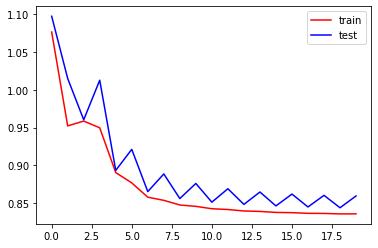

In [0]:
def test_info(info, train_msk, test_msk):
    temp_df = pd.DataFrame()
    temp_info = {}
    ignore = []

    for col in info:
        temp_info[col['name']] = col
        if col['type'] == 'calc':
            exec(col['code'],{"df":temp_df})
            
        elif col['name'] not in df.columns:
            raise ValueError('Нет колонки с именем '+col['name'])
        elif col['type'] == 'choice':
            if 'separate' in col and col['separate']:
                for ans in col['answers']:
                    temp_df[col['name']+'_'+ans] = (df[col['name']] == ans).astype('float32')
            else:
                temp_df[col['name']] = df[col['name']].apply(lambda x:col['answers'][x]).astype('float32')
        elif col['type'] == 'numeric':
            temp_df[col['name']] = df[col['name']].astype('float32')

    
    for col in info:
        if 'ignore' in col and col['ignore']:
            temp_df.drop(columns=col['name'], inplace=True)
    
    cnt = 0
    for col in info:
        if 'ignore' in col and col['ignore']:
            continue
        if col['type'] == 'code' or col['type'] == 'numeric' or not ('separate' in col and col['separate']):
            m = temp_df[col['name']].mean()
            std = temp_df[col['name']].std(ddof=0)
            temp_df[col['name']] = (temp_df[col['name']] - m) / std
            temp_info[col['name']]['mean'] = m
            temp_info[col['name']]['std'] = std
            cnt += 1
        else:
            cnt += len(col['answers'])
    assert len(temp_df.columns) == cnt
    x_train_t = torch.tensor(temp_df[train_msk].values).float().to(device)
    y_train_t = torch.tensor(y[train_msk].values).float().to(device)
    y_train_t = y_train_t.view(y_train_t.shape[0], 1)
    x_test_t = torch.tensor(temp_df[test_msk].values).float().to(device)
    y_test_t = torch.tensor(y[test_msk].values).float().to(device)
    y_test_t = y_test_t.view(y_test_t.shape[0], 1)
    cnts = list(range(3,7))
    act_f = [
         'sigmoid',
         'tanh'
    ]
    optim = [
        torch.optim.SGD
    ]
    err_f = [
         torch.nn.MSELoss(),
    ]
    nn_res, score_res = train_best(x_train_t,                        # x_train
                y_train_t,   # y_train
                x_test_t,                         # x_test
                y_test_t,    # y_test
                cnts,                           # hidden_cnt
                act_f,                          # act_f
                optim,                          # optim
                err_f,                          # err_f     
                torch.nn.L1Loss(),              # err_cmp
                np.logspace(1e-5,1e-2).tolist(),# lrs
                epochs,                          # epochs
                tries                              # nn_count
                )
    info_res = []
    for col in info:
        info_res.append(temp_info[col['name']])
    return nn_res, score_res, info_res
      
nmask =  np.random.rand(len(df)) < train_ratio
nns, score, ninfo = test_info(info['columns'], nmask, ~nmask)

No wh  BMI Devine Age Life Fam-Sep Ed-Sep


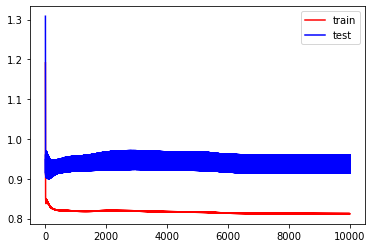

No wh  BMI Devine Age Life Fam Ed-Sep


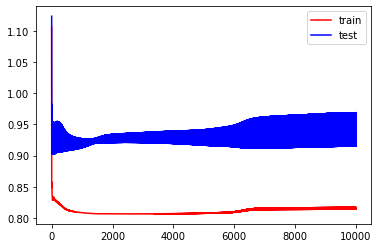

No wh  BMI Devine Age Life Fam-Sep Ed


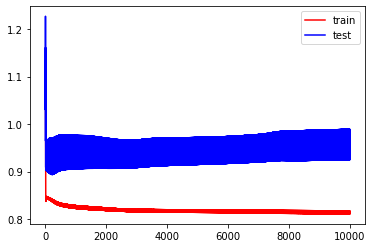

No wh  BMI Devine Age Life Fam Ed


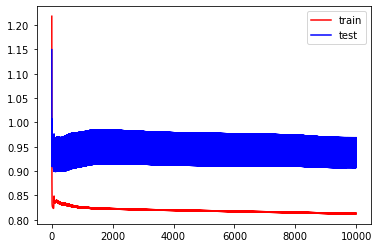

No wh  BMI Devine Age


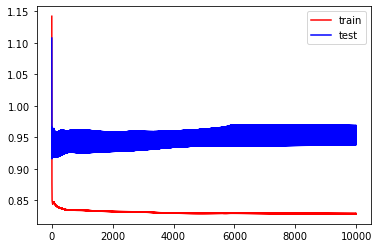

No wh  BMI Devine Life Fam-Sep Ed-Sep


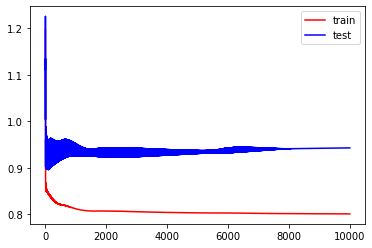

No wh  BMI Devine Life Fam Ed-Sep


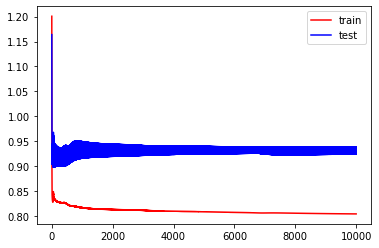

No wh  BMI Devine Life Fam-Sep Ed


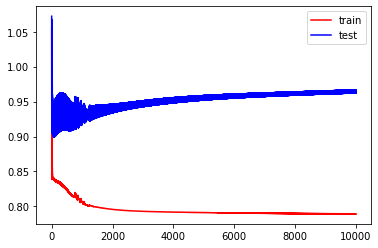

No wh  BMI Devine Life Fam Ed


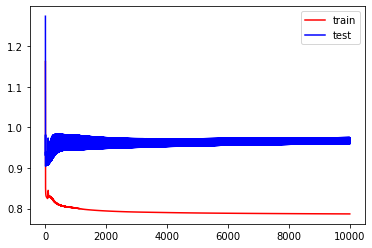

No wh  BMI Devine


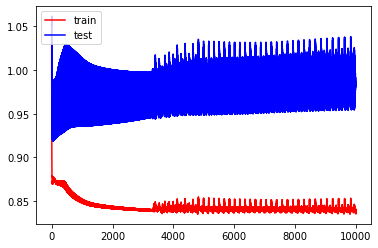

No wh  BMI Age Life Fam-Sep Ed-Sep


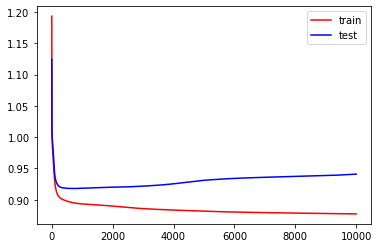

No wh  BMI Age Life Fam Ed-Sep


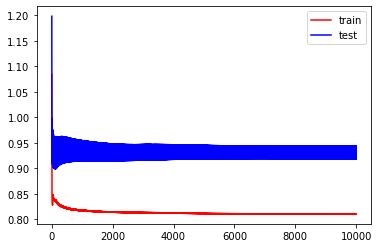

No wh  BMI Age Life Fam-Sep Ed


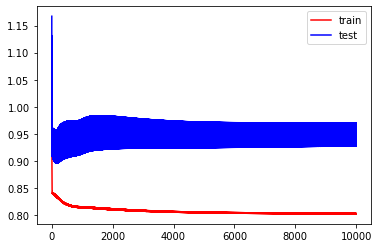

No wh  BMI Age Life Fam Ed


No wh  BMI Age


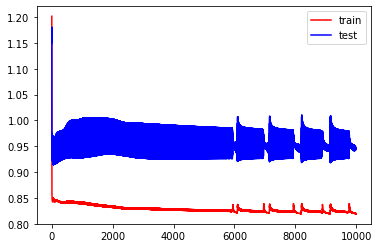

No wh  BMI Life Fam-Sep Ed-Sep


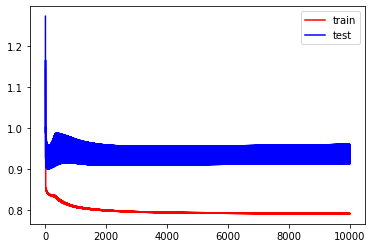

No wh  BMI Life Fam Ed-Sep


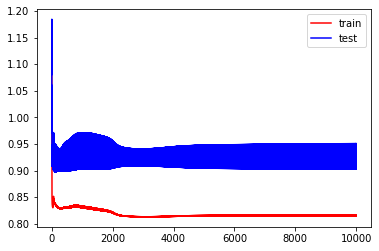

No wh  BMI Life Fam-Sep Ed


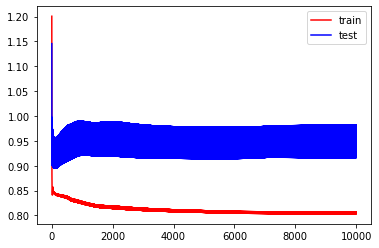

No wh  BMI Life Fam Ed


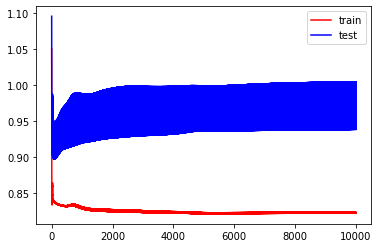

No wh  BMI


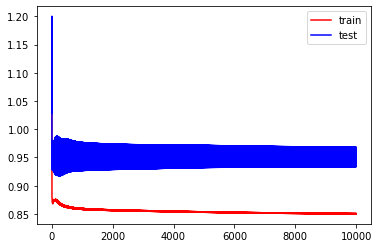

No wh  Devine Age Life Fam-Sep Ed-Sep


No wh  Devine Age Life Fam Ed-Sep


No wh  Devine Age Life Fam-Sep Ed


No wh  Devine Age Life Fam Ed


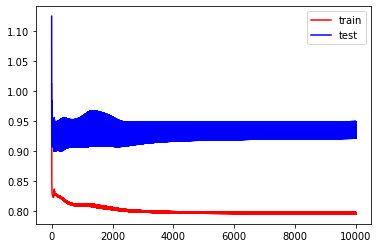

No wh  Devine Age


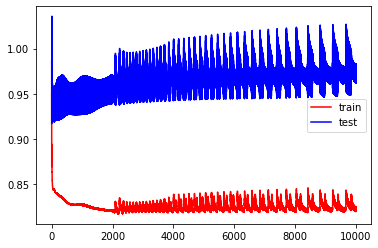

No wh  Devine Life Fam-Sep Ed-Sep


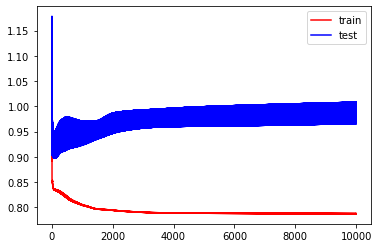

No wh  Devine Life Fam Ed-Sep


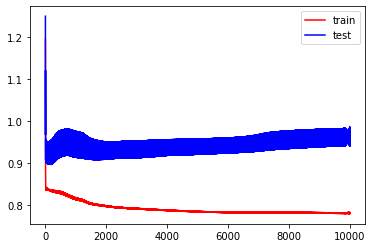

No wh  Devine Life Fam-Sep Ed


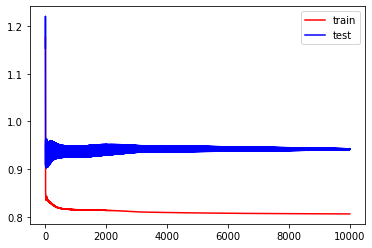

No wh  Devine Life Fam Ed


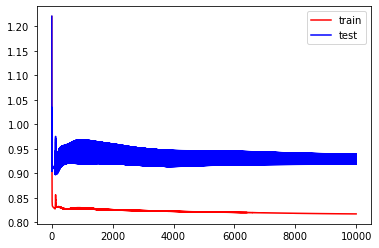

No wh  Devine


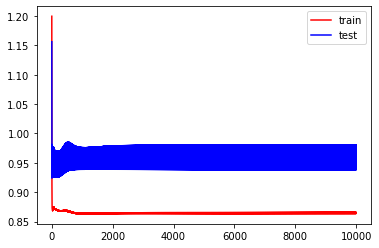

No wh  Age Life Fam-Sep Ed-Sep


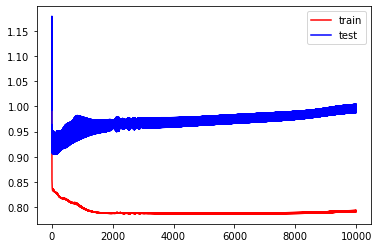

No wh  Age Life Fam Ed-Sep


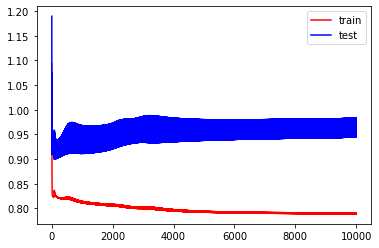

No wh  Age Life Fam-Sep Ed


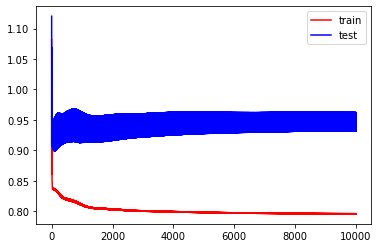

No wh  Age Life Fam Ed


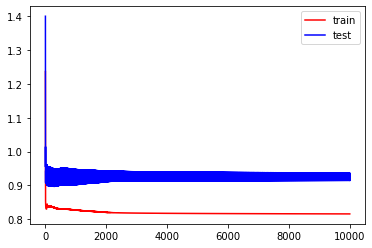

No wh  Age


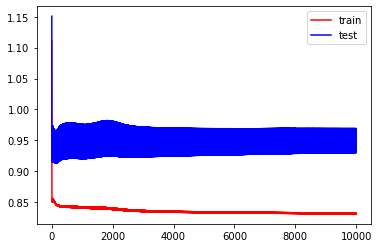

No wh  Life Fam-Sep Ed-Sep


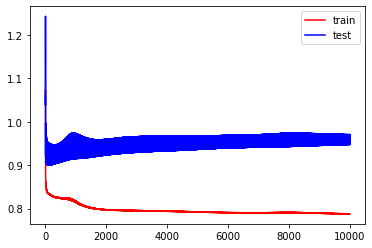

No wh  Life Fam Ed-Sep


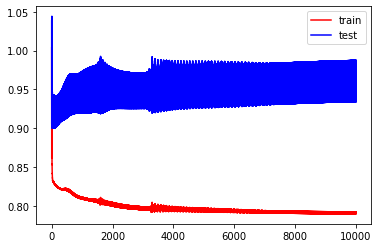

No wh  Life Fam-Sep Ed


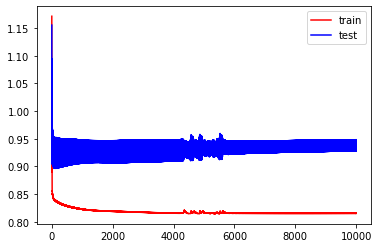

No wh  Life Fam Ed


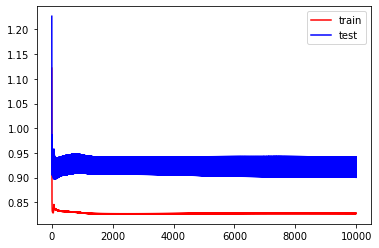

No wh 


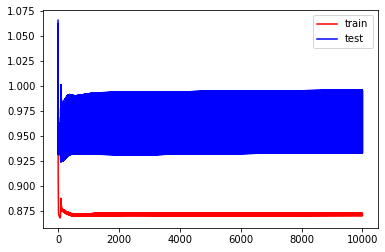

Wh  BMI Devine Age Life Fam-Sep Ed-Sep


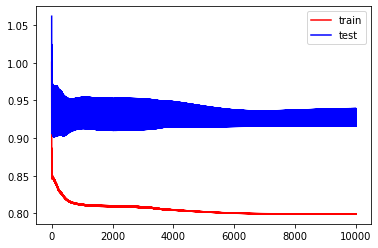

Wh  BMI Devine Age Life Fam Ed-Sep


Wh  BMI Devine Age Life Fam-Sep Ed


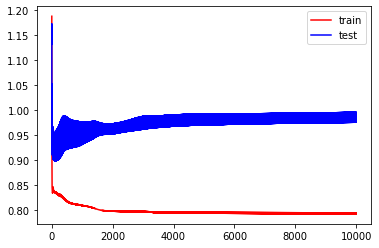

Wh  BMI Devine Age Life Fam Ed


Wh  BMI Devine Age


Wh  BMI Devine Life Fam-Sep Ed-Sep


Wh  BMI Devine Life Fam Ed-Sep


Wh  BMI Devine Life Fam-Sep Ed


Wh  BMI Devine Life Fam Ed


Wh  BMI Devine


Wh  BMI Age Life Fam-Sep Ed-Sep


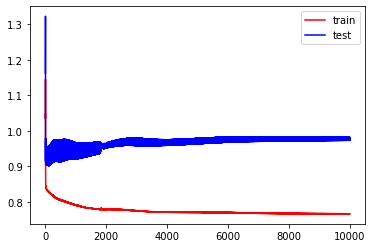

Wh  BMI Age Life Fam Ed-Sep


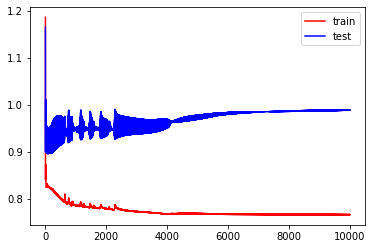

Wh  BMI Age Life Fam-Sep Ed


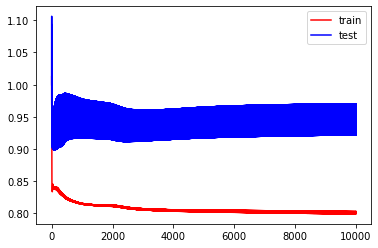

Wh  BMI Age Life Fam Ed


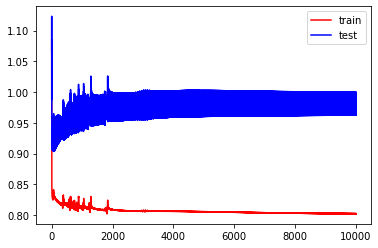

Wh  BMI Age


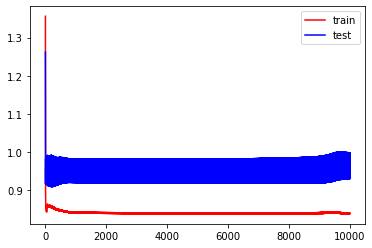

Wh  BMI Life Fam-Sep Ed-Sep


Wh  BMI Life Fam Ed-Sep


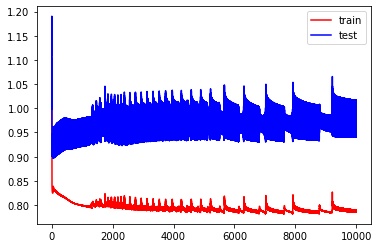

Wh  BMI Life Fam-Sep Ed


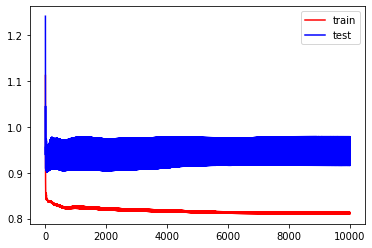

Wh  BMI Life Fam Ed


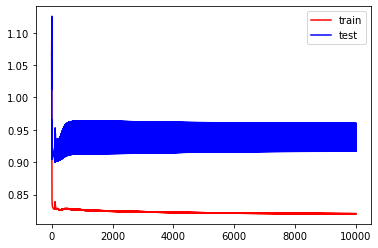

Wh  BMI


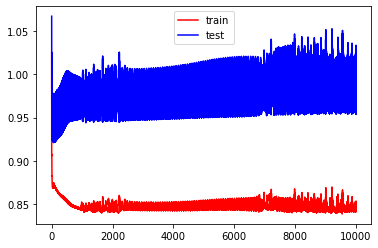

Wh  Devine Age Life Fam-Sep Ed-Sep


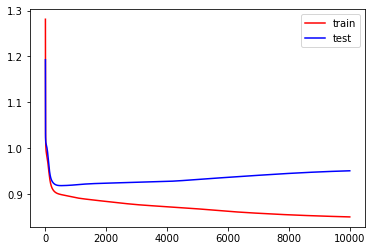

Wh  Devine Age Life Fam Ed-Sep


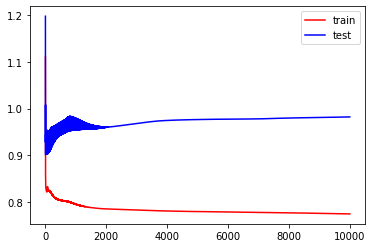

Wh  Devine Age Life Fam-Sep Ed


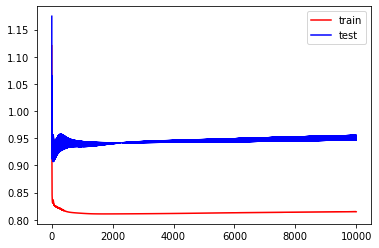

Wh  Devine Age Life Fam Ed


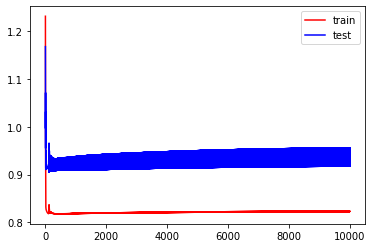

Wh  Devine Age


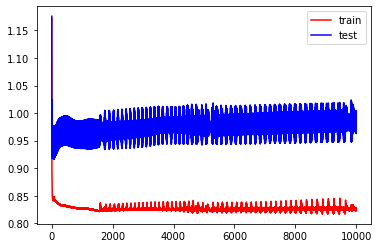

Wh  Devine Life Fam-Sep Ed-Sep


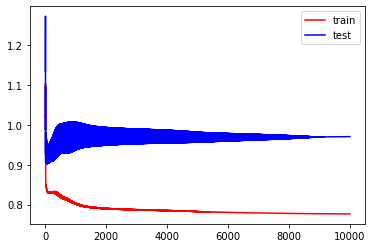

Wh  Devine Life Fam Ed-Sep


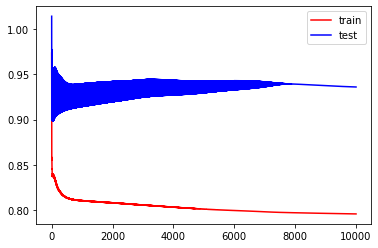

Wh  Devine Life Fam-Sep Ed


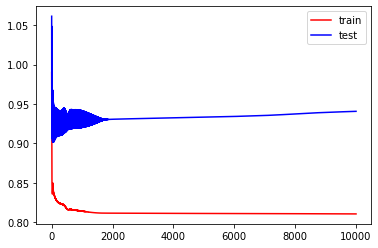

Wh  Devine Life Fam Ed


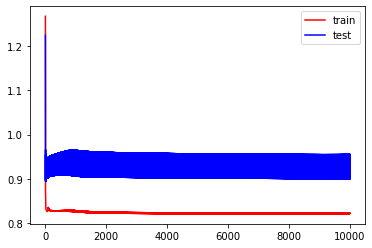

Wh  Devine


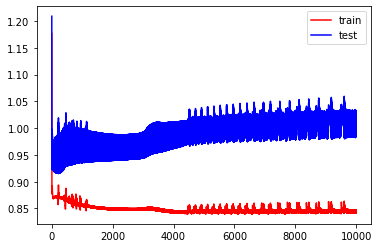

Wh  Age Life Fam-Sep Ed-Sep


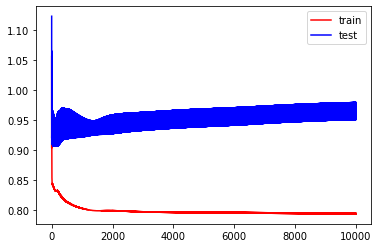

Wh  Age Life Fam Ed-Sep


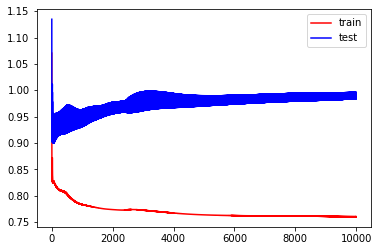

Wh  Age Life Fam-Sep Ed


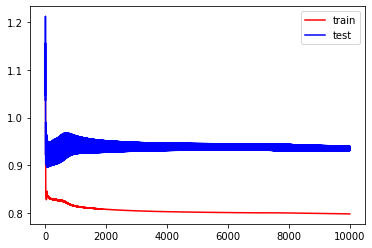

Wh  Age Life Fam Ed


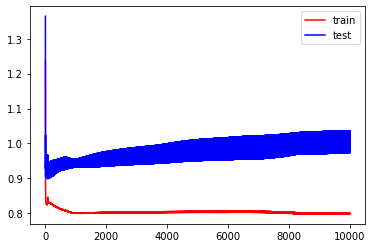

Wh  Age


Wh  Life Fam-Sep Ed-Sep


Wh  Life Fam Ed-Sep


Wh  Life Fam-Sep Ed


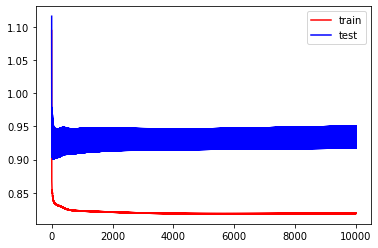

Wh  Life Fam Ed


Wh 


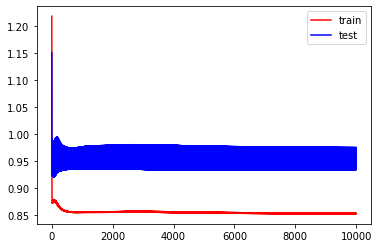

In [0]:
random.seed(42)
np.random.seed(42)
epochs =  10000#@param {type:"integer"}
tries =  5#@param {type:"integer"}
nmask =  np.random.rand(len(df)) < train_ratio
ult_best_score = None
ult_best_model_info = None
ult_best_nn = None
for con in tqdm(configs):
    print(con['name'])
    nn_res, score, ninfo = test_info(con['columns'], nmask, ~nmask)
    model_info = {
        'model': {
            'hidden_cnt':nn_res.hidden_cnt,
            'act_function':str(nn_res.act_function_name),
            'quality': score
        },
        'columns': ninfo,
        'name': con['name']
    }
    torch.save(nn_res.state_dict(), '/gdrive/My Drive/Colab Notebooks/'+ con['name'] +'.pt')
    with open('/gdrive/My Drive/Colab Notebooks/'+ con['name'] +'.json','w')as out:
        out.write(json.dumps(model_info))
    if ult_best_score == None or score < ult_best_score:
        ult_best_score = score
        ult_best_model_info = model_info
        ult_best_nn = nn_res
torch.save(nn_res.state_dict(), '/gdrive/My Drive/Colab Notebooks/best_model.pt')
with open('/gdrive/My Drive/Colab Notebooks/best_model.json','w')as out:
    out.write(json.dumps(ult_best_model_info))

In [0]:
result = {
    'quality':{},
    'Wh':{},
    'BMI':{},
    'Devine':{},
    'Age':{},
    'Life':{}
}
for con in configs:
    try:
        with open('/gdrive/My Drive/Colab Notebooks/'+con['name']+'.json','r') as inp:
            info_c = json.load(inp)
            result['quality'][info_c['name']] = info_c['model']['quality']
            result['Wh'][info_c['name']] = 'Wh' in info_c['name']
            result['BMI'][info_c['name']] = 'BMI' in info_c['name']
            result['Devine'][info_c['name']] = 'Devine' in info_c['name']
            result['Age'][info_c['name']] = 'Age' in info_c['name']
            result['Life'][info_c['name']] = 'Life' in info_c['name']
    except   Exception as e:
        print(str(e))
resultdf = pd.DataFrame(result).sort_values(by=['quality']) 
pd.set_option('display.max_rows', resultdf.shape[0]+1)
resultdf

quality     Wh  ...    Age   Life
No wh  BMI Age Life Fam-Sep Ed-Sep         0.784857  False  ...   True   True
Wh  Devine Age Life Fam-Sep Ed-Sep         0.787968   True  ...   True   True
Wh  Age Life Fam Ed                        0.809040   True  ...   True   True
No wh  BMI Devine Life Fam Ed              0.809069  False  ...  False   True
No wh  Life Fam Ed                         0.809107  False  ...  False   True
No wh  Devine Age Life Fam-Sep Ed          0.809108  False  ...   True   True
Wh  Age Life Fam-Sep Ed                    0.809161   True  ...   True   True
Wh  Age Life Fam Ed-Sep                    0.809190   True  ...   True   True
Wh  BMI Age Life Fam Ed-Sep                0.809583   True  ...   True   True
Wh  BMI Devine Age Life Fam Ed             0.809643   True  ...   True   True
No wh  Devine Age Life Fam Ed              0.809829  False  ...   True   True
No wh  Life Fam Ed-Sep                     0.809928  False  ...  False   True
No wh  Age Life Fam Ed-Sep                 0.810154  False  ...   True   True
No wh  Devine Life Fam Ed                  0.810407  False  ...  False   True
No wh  Age Life Fam Ed                     0.810474  False  ...   True   True
No wh  Age Life Fam-Sep Ed-Sep             0.810514  False  ...   True   True
No wh  Life Fam-Sep Ed                     0.810728  False  ...  False   True
Wh  Devine Age Life Fam Ed-Sep             0.810896   True  ...   True   True
No wh  BMI Age Life Fam-Sep Ed             0.810995  False  ...   True   True
No wh  Age Life Fam-Sep Ed                 0.810996  False  ...   True   True
No wh  BMI Devine Age Life Fam-Sep Ed      0.811095  False  ...   True   True
Wh  BMI Age Life Fam Ed                    0.811237   True  ...   True   True
No wh  BMI Age Life Fam Ed                 0.811482  False  ...   True   True
No wh  Devine Life Fam-Sep Ed-Sep          0.811675  False  ...  False   True
No wh  BMI Life Fam Ed                     0.811745  False  ...  False   True
No wh  BMI Devine Life Fam-Sep Ed          0.812087  False  ...  False   True
Wh  Devine Age Life Fam-Sep Ed             0.812218   True  ...   True   True
No wh  Life Fam-Sep Ed-Sep                 0.812297  False  ...  False   True
No wh  BMI Age Life Fam Ed-Sep             0.812433  False  ...   True   True
Wh  BMI Devine Age Life Fam Ed-Sep         0.812590   True  ...   True   True
No wh  BMI Devine Age Life Fam-Sep Ed-Sep  0.812671  False  ...   True   True
No wh  Devine Life Fam Ed-Sep              0.812682  False  ...  False   True
No wh  BMI Age                             0.812719  False  ...   True  False
No wh  Devine Age Life Fam Ed-Sep          0.812973  False  ...   True   True
Wh  BMI Life Fam Ed                        0.813055   True  ...  False   True
No wh  Age                                 0.813073  False  ...   True  False
Wh  Devine Life Fam-Sep Ed-Sep             0.813189   True  ...  False   True
Wh  BMI Devine Age Life Fam-Sep Ed         0.813234   True  ...   True   True
No wh  Devine Life Fam-Sep Ed              0.813403  False  ...  False   True
No wh  Devine Age Life Fam-Sep Ed-Sep      0.813428  False  ...   True   True
No wh  BMI Devine Age Life Fam Ed          0.813448  False  ...   True   True
Wh  Devine Age Life Fam Ed                 0.813699   True  ...   True   True
Wh  BMI Devine Life Fam Ed                 0.813873   True  ...  False   True
No wh  BMI Life Fam-Sep Ed                 0.813876  False  ...  False   True
Wh  Life Fam-Sep Ed                        0.813898   True  ...  False   True
Wh  BMI Age Life Fam-Sep Ed                0.813904   True  ...   True   True
No wh  BMI Life Fam Ed-Sep                 0.814070  False  ...  False   True
Wh  Devine Life Fam-Sep Ed                 0.814074   True  ...  False   True
Wh  BMI Age Life Fam-Sep Ed-Sep            0.814127   True  ...   True   True
Wh  BMI Devine Age                         0.814329   True  ...   True  False
Wh  BMI Life Fam-Sep Ed-Sep                0.814404   True  ...  F

In [0]:
data = {
    'BMI':{
        'mean'  :   resultdf[resultdf['BMI'] == True]['quality'].mean(),
        'std'   :   resultdf[resultdf['BMI'] == True]['quality'].std(),
        'min'   :   resultdf[resultdf['BMI'] == True]['quality'].min()
    },
    'Devine':{
        'mean'  :   resultdf[resultdf['Devine'] == True]['quality'].mean(),
        'std'   :   resultdf[resultdf['Devine'] == True]['quality'].std(),
        'min'   :   resultdf[resultdf['Devine'] == True]['quality'].min()
    },
    'Wh':{
        'mean'  :   resultdf[resultdf['Wh'] == True]['quality'].mean(),
        'std'   :   resultdf[resultdf['Wh'] == True]['quality'].std(),
        'min'   :   resultdf[resultdf['Wh'] == True]['quality'].min()
    }
}
pd.DataFrame(data)

BMI    Devine        Wh
mean  0.814218  0.814391  0.814461
std   0.006370  0.006385  0.006143
min   0.784857  0.787968  0.787968

In [0]:
data = {
    'only Age':{
        'mean'  :   resultdf[(resultdf['Age'] == True) & (resultdf['Life'] == False)]['quality'].mean(),
        'std'   :   resultdf[(resultdf['Age'] == True) & (resultdf['Life'] == False)]['quality'].std(),
        'min'   :   resultdf[(resultdf['Age'] == True) & (resultdf['Life'] == False)]['quality'].min()
    },
    'no Age':{
        'mean'  :   resultdf[resultdf['Age'] == False]['quality'].mean(),
        'std'   :   resultdf[resultdf['Age'] == False]['quality'].std(),
        'min'   :   resultdf[resultdf['Age'] == False]['quality'].min()
    }
}
pd.DataFrame(data)

only Age    no Age
mean  0.817119  0.816193
std   0.004515  0.005436
min   0.812719  0.809069

In [0]:
with open('/gdrive/My Drive/Colab Notebooks/best_model.json','r') as inp:
    best_info = json.load(inp)
random.seed(42)
np.random.seed(42)
epochs =  20000#@param {type:"integer"}
tries =  25#@param {type:"integer"}
nmask =  np.random.rand(len(df)) < train_ratio 
nn_res, score, ninfo = test_info(best_info['columns'], nmask, ~nmask)
print(score)

0.815141499042511


In [0]:
temp_df = pd.DataFrame()
info = best_info['columns']
temp_info = {}
ignore = []
col_info = {}
for col in info:
    temp_info[col['name']] = col
    if col['type'] == 'calc':
        exec(col['code'],{"df":temp_df})
        
    elif col['name'] not in df.columns:
        raise ValueError('Нет колонки с именем '+col['name'])
    elif col['type'] == 'choice':
        if 'separate' in col and col['separate']:
            for ans in col['answers']:
                temp_df[col['name']+'_'+ans] = (df[col['name']] == ans).astype('float32')
        else:
            temp_df[col['name']] = df[col['name']].apply(lambda x:col['answers'][x]).astype('float32')
    elif col['type'] == 'numeric':
        temp_df[col['name']] = df[col['name']].astype('float32')
    
for col in info:
    if 'ignore' in col and col['ignore']:
        temp_df.drop(columns=col['name'], inplace=True)
    
cnt = 0
for col in info:
    if 'ignore' in col and col['ignore']:
        continue
    if col['type'] == 'code' or col['type'] == 'numeric' or not ('separate' in col and col['separate']):
        m = temp_df[col['name']].mean()
        std = temp_df[col['name']].std(ddof=0)
        temp_df[col['name']] = (temp_df[col['name']] - m) / std
        temp_info[col['name']]['mean'] = m
        temp_info[col['name']]['std'] = std
        cnt += 1
    else:
        cnt += len(col['answers'])
assert len(temp_df.columns) == cnt

individs = temp_df.sample(n=20, random_state=42)
individs

Пол  ...  Образование_Среднее профессиональное
196  -0.578574  ...                                   0.0
3420 -0.578574  ...                                   0.0
2918 -0.578574  ...                                   0.0
2309 -0.578574  ...                                   0.0
1663  1.728317  ...                                   0.0
2622 -0.578574  ...                                   0.0
2676 -0.578574  ...                                   0.0
3717 -0.578574  ...                                   0.0
2854 -0.578574  ...                                   0.0
1879 -0.578574  ...                                   0.0
1580 -0.578574  ...                                   1.0
4163  1.728317  ...                                   0.0
4067 -0.578574  ...                                   1.0
1574 -0.578574  ...                                   0.0
3484 -0.578574  ...                                   0.0
1247  1.728317  ...                                   0.0
393  -0.578574  ...                                   0.0
1101  1.728317  ...                                   0.0
2664  1.728317  ...                                   0.0
18   -0.578574  ...                                   0.0

[20 rows x 17 columns]

In [0]:
for label in ['Пол',	'Детство',	'Потеря родителей',	'Родственники',	'Творчество', 'Умственный труд', 'Близкие',	'Индекс массы тела (BMI)', 'Возраст']:
    input_df = individs.copy(True)
    vals = temp_df[label].unique().tolist()
    if len(vals) > 20:
        vals = random.sample(vals, 20)
    results = {}
    for val in vals:
        input_df[label] = val
        input_t = torch.tensor(input_df.values).float().to(device)
        results[val]=nn_res(input_t).mean()
    results = sorted([(k*temp_info[label]['std'] + temp_info[label]['mean'], v) for k, v in results.items()], key = lambda x:x[0] )
    plt.title(label)
    plt.plot([i[0] for i in results],[i[1] for i in results])
    plt.show()

KeyError: ignored

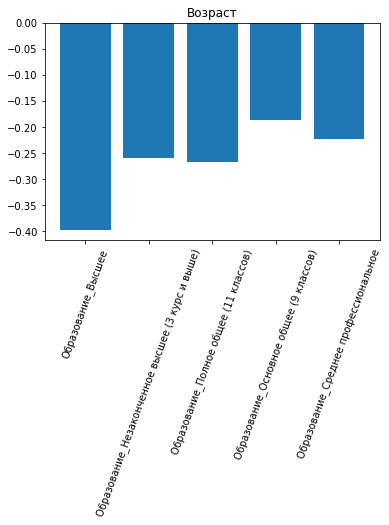

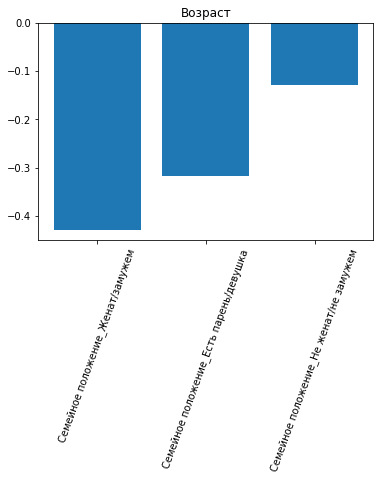

In [0]:
for i in ['Образование', 'Семейное положение']:
    vals = []
    for col in temp_df.columns:
        if i in col:
            vals.append(col)
    input_df = individs.copy(True)
    results = {}
    for val in vals:
        for t in vals:
            input_df[t] = 1.0 if val == t else 0.0
      
        input_t = torch.tensor(input_df.values).float().to(device)
        results[val]=nn_res(input_t).mean()
    plt.title(label)
    plt.bar(list(results.keys()),list(results.values()))
    plt.xticks(rotation=70)
    plt.show()